## Predicting Follicle Growth for Egg Retrieval
  
My wife and I currently building our family through IVF. To do so, I am undergoing a process that stimulates my ovaries to grow a lot of eggs (follicles) so that they can be retrieved and fertilized in a petri dish. Science is cool :). To know when to do the retrieval, the doctors must monitor my follicle growth closely. Once ~3 are greater than 20mm, I will take some medication to initiate the ovulation process ("trigger shot") and the doctor will subseqeuntly retrieve the eggs. However, we don't know when 3 follicles will be greater than 20mm. Being the nerdy scientist I am, I decided to predict the most likely day when that will happen!  

**Question**  
When will I have 3 follicles greater than 20mm?
  
**Assumptions**  
1) Since neither myself nor the doctor have anyway of knowing which follicle is which from day to day, I made an assumption in which the biggest follicle always stayed the biggest, the 2nd biggest always stayed the 2nd biggest, etc.  
2) Follicles grow linearly, therefore, linear regression is the appropriate machine learning technique to use

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [5]:
current_file = '../Follicle_Growth.csv'

def import_data(current_fiel):
    data = pd.read_csv(current_file)

    data.rename(columns={'Unnamed: 1': 'Data'}, inplace=True)
    data.index = data['Data']
    del data['Data']
    del data['Unnamed: 0']
    data = data.transpose()
    return data

data = import_data(current_file)
data.head()

Data,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,Estradiol,Progesterone,Uterine Lining
9/6/2017,12.0,12.0,9.0,9.0,9.0,9.0,9.0,0.0,0.0,0.0,11.0,9.0,9.0,9.0,9.0,9.0,9.0,296.0,0.5,4.9
9/7/2017,13.5,12.0,10.0,9.0,9.0,9.0,9.0,0.0,0.0,0.0,13.0,9.0,9.0,9.0,9.0,9.0,9.0,461.0,0.5,7.6
9/8/2017,15.0,13.5,11.5,11.0,10.0,10.0,9.0,9.0,9.0,0.0,15.5,12.0,11.0,9.0,9.0,9.0,9.0,918.0,0.5,8.4


Each numbered column represents and individual follicle (see **Assumptions**) measured over 3 days. Other data inlcuding my estrogen and progesterone levels and my uterine lining is included. Potentially this data could be included as well, though it is less infromative for the trigger day.  
  
Looking at the columns that represent individual follicles, there are 3 columns that have 0.0 as measurements. Likely, they were not actually 0.0; rather, they were too small to observe so 0.0 is not accurate. Let's fill them with NaNs instead, and get rid of the column that is only filled with 0.0.

In [6]:
def clean_up_df(df):
    df = df.loc[:, (df != 0).any(axis=0)]
    df = df.where(df!=0.0, np.nan) 
    return df

data = clean_up_df(data)
data.head()

Data,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,Estradiol,Progesterone,Uterine Lining
9/6/2017,12.0,12.0,9.0,9.0,9.0,9.0,9.0,NaN,NaN,11.0,9.0,9.0,9.0,9.0,9.0,9.0,296.0,0.5,4.9
9/7/2017,13.5,12.0,10.0,9.0,9.0,9.0,9.0,NaN,NaN,13.0,9.0,9.0,9.0,9.0,9.0,9.0,461.0,0.5,7.6
9/8/2017,15.0,13.5,11.5,11.0,10.0,10.0,9.0,9.0,9.0,15.5,12.0,11.0,9.0,9.0,9.0,9.0,918.0,0.5,8.4


Now that the data is cleaned up, let's get a basic plot of how the growth looks. 

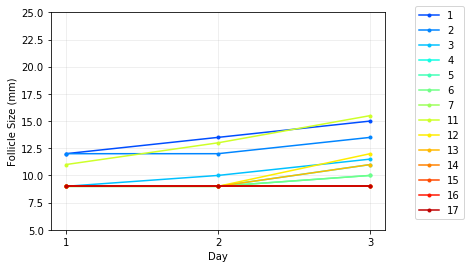

In [14]:
from matplotlib import cm

def color_picker(start, end, num_lines):
    
    cm_subsection = np.linspace(start, end, num_lines)
    colors = [cm.jet(x) for x in cm_subsection]
    return colors

def plot_data(df, xlabel, ylabel):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111, ylabel=ylabel)
    
    colors = color_picker(0.2, 1.0, 15)

    column_names = data.columns.tolist()
    xs_names = data.index.tolist()
    xs = np.array([1,2,3])

    for i, col in enumerate(column_names):
        if i < 14:
            ax1.plot(xs, data[col], color=colors[i], linestyle='-', marker='.')
    
    ticks = np.arange(1,4,1)
    ax1.set_xticks(ticks)
    plt.xlabel(xlabel)
    ax1.set_ylim(5,25)
    ax1.grid(alpha=0.25)
    ax1.legend(bbox_to_anchor=(1.25, 1.05))
    
plot_data(data, 'Day', 'Follicle Size (mm)')
plt.show()
    

Those follicles are growing! Looks like there are 3 in the lead (1, 2, 11) that are greater than 12mm and the rest are cathcing up. Based on these 3 data points for each follicle, we can use linear regression (see **Assumptions**) to determine when 3 follicles will be greater than 20mm. 

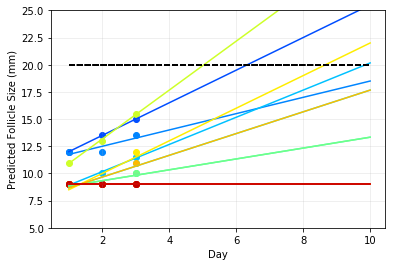

In [15]:
def drop_cols_with_nan(df):
    df.dropna(axis=1, how='any', inplace=True)
    return df

def predict_future(df, xs, start_day, end_day, cut_off):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    predict_xs = np.arange(start_day, end_day, 1)
    
    data_train = drop_cols_with_nan(data)
    column_names = data_train.columns.tolist()
    for i, col in enumerate(column_names):
        if i < 15:
            lin_regr = linear_model.LinearRegression()
            y_data = np.asarray(data_train[col])
            lin_regr.fit(np.transpose(np.matrix(xs)), np.transpose(np.matrix(y_data)))
            ax = plot_predictions(xs, y_data, predict_xs, lin_regr, i, ax1)
            plot_cutoff(cut_off, predict_xs, ax)
    return ax

def plot_predictions(xs, y_train, predict_xs, lin_regr, i, ax1):
    
    colors = color_picker(0.2, 1.0, 15)
    ax1.scatter(xs, y_train, color=colors[i])
    ax1.plot(predict_xs, lin_regr.predict(np.transpose(np.matrix(predict_xs))), color=colors[i])
    ax1.set_ylim(5,25)
    ax1.set_ylabel('Predicted Follicle Size (mm)')
    ax1.set_xlabel('Day')
    ax1.grid(alpha=0.25)
    return ax1

def plot_cutoff(cut_off, predict_xs, ax):
    line = [cut_off]*len(predict_xs)
    ax.plot(predict_xs, line, color='k', linestyle='--')      

xs = [1,2,3]
ax = predict_future(data, xs, 1, 11, 20)
ax.legend(bbox_to_anchor=(1.25, 1.05))
    
plt.show()


The above plot depicts the usage of linear regression to predict follicle growth over an additional 7 days (10 days total are plotted; the first 3 from which the prediction came, and 7 future days predicted from linear regression). The black dotted line represents the magic cutoff size of 20 mm; therefore, when 3 lines cross the black dotted line, we are in business! Assuming that linear regression was the correct predictive regression to use, this chart suggests that I will take my trigger shot between Day 8 and Day 9 as the light green, the blue, and the yellow line have all crossed the 20mm threshold.  
  
**Conclusions**  
My trigger shot will be between Day 8 and Day 9, which corresponds to Wednesday September 13th and Thursday September 14th.